In [24]:
from numpy import asarray
import pandas as pd
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

In [2]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

In [3]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

In [4]:
# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = RandomForestRegressor(n_estimators=1000)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0]

In [12]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    print(f"tarin={train}, test={test}")
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = random_forest_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions

In [39]:
# load the dataset
series = pd.read_csv('retails.csv', header=0, index_col=0)
#series1 = series['Sales']
series.set_index('Order Date',inplace=True)
#print(series1)
#print(series)
values = series.values
#print(values)
#transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)
print(data)

[[122497.  66030. 247156. 203258. 164263. 206064. 220986.]
 [ 66030. 247156. 203258. 164263. 206064. 220986. 230161.]
 [247156. 203258. 164263. 206064. 220986. 230161. 382200.]
 [203258. 164263. 206064. 220986. 230161. 382200. 241726.]
 [164263. 206064. 220986. 230161. 382200. 241726. 480979.]
 [206064. 220986. 230161. 382200. 241726. 480979. 410279.]
 [220986. 230161. 382200. 241726. 480979. 410279.  89009.]
 [230161. 382200. 241726. 480979. 410279.  89009.  90823.]
 [382200. 241726. 480979. 410279.  89009.  90823. 212164.]
 [241726. 480979. 410279.  89009.  90823. 212164. 237272.]
 [480979. 410279.  89009.  90823. 212164. 237272. 222722.]
 [410279.  89009.  90823. 212164. 237272. 222722. 205388.]
 [ 89009.  90823. 212164. 237272. 222722. 205388. 215776.]
 [ 90823. 212164. 237272. 222722. 205388. 215776. 229543.]
 [212164. 237272. 222722. 205388. 215776. 229543. 429658.]
 [237272. 222722. 205388. 215776. 229543. 429658. 249639.]
 [222722. 205388. 215776. 229543. 429658. 249639. 477720

In [40]:
# evaluate
mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae)

tarin=[[122497.  66030. 247156. 203258. 164263. 206064. 220986.]
 [ 66030. 247156. 203258. 164263. 206064. 220986. 230161.]
 [247156. 203258. 164263. 206064. 220986. 230161. 382200.]
 [203258. 164263. 206064. 220986. 230161. 382200. 241726.]
 [164263. 206064. 220986. 230161. 382200. 241726. 480979.]
 [206064. 220986. 230161. 382200. 241726. 480979. 410279.]
 [220986. 230161. 382200. 241726. 480979. 410279.  89009.]
 [230161. 382200. 241726. 480979. 410279.  89009.  90823.]
 [382200. 241726. 480979. 410279.  89009.  90823. 212164.]
 [241726. 480979. 410279.  89009.  90823. 212164. 237272.]
 [480979. 410279.  89009.  90823. 212164. 237272. 222722.]
 [410279.  89009.  90823. 212164. 237272. 222722. 205388.]
 [ 89009.  90823. 212164. 237272. 222722. 205388. 215776.]
 [ 90823. 212164. 237272. 222722. 205388. 215776. 229543.]
 [212164. 237272. 222722. 205388. 215776. 229543. 429658.]
 [237272. 222722. 205388. 215776. 229543. 429658. 249639.]
 [222722. 205388. 215776. 229543. 429658. 249639. 

In [41]:
print(y)
print(yhat)

[234739. 166267. 355704. 310150. 367411. 354902. 337092. 331014. 705680.
 443898. 683410. 687245.]
[298167.566, 377964.243, 216667.851, 248497.577, 387213.168, 380192.232, 378593.065, 380191.826, 361388.593, 424817.651, 367820.917, 499462.584]


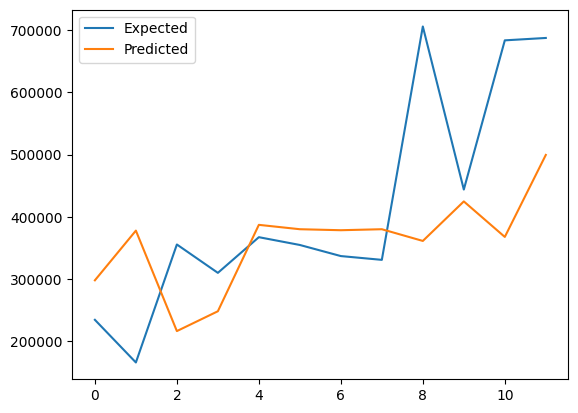

In [42]:
# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

In [43]:
print(mae)

123194.07724999999
